In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pathlib import Path

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 300)

In [109]:
suj = 'antisacadas_91'
df = pd.read_csv(f'./raw_data/{suj}.csv')
df.head(5)

rt                                           stimulus  \
0   1006.0  \n    <div style="left: calc(50% - 400px); wid...   
1   7178.0                                                NaN   
2    709.0  \n    <div style="left: calc(50% - 400px); wid...   
3  46036.0                                                NaN   
4   5546.0  \n    <div style="left: calc(50% - 400px); wid...   

                                            response            trial_type  \
0                                                  0  html-button-response   
1  {"anteojos":"no","age":"33","hand":"derecha","...      survey-html-form   
2                                                  0  html-button-response   
3                                                NaN      virtual-chinrest   
4                                                  0  html-button-response   

   trial_index  time_elapsed internal_node_id  run_id  condition  \
0            0          1010          0.0-0.0      91          1   
1            1          8193          0.0-1.0      91          1   
2            2          8904          0.0-2.0      91          1   
3            3         54943          0.0-3.0      91          1   
4            4         60493          0.0-4.0      91          1   

           recorded_at               source_code_version  ip  \
0  2023-02-07 20:55:05  ba99e1b51ad05fbf3d7a37345e407160 NaN   
1  2023-02-07 20:55:05  ba99e1b51ad05fbf3d7a37345e407160 NaN   
2  2023-02-07 20:55:05  ba99e1b51ad05fbf3d7a37345e407160 NaN   
3  2023-02-07 20:55:05  ba99e1b51ad05fbf3d7a37345e407160 NaN   
4  2023-02-07 20:55:05  ba99e1b51ad05fbf3d7a37345e407160 NaN   

                                          user_agent  device browser  \
0  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...  WebKit  Chrome   
1  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...  WebKit  Chrome   
2  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...  WebKit  Chrome   
3  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...  WebKit  Chrome   
4  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...  WebKit  Chrome   

  browser_version platform  platform_version  item_width_mm  item_height_mm  \
0       107.0.0.0    Linux               NaN            NaN             NaN   
1       107.0.0.0    Linux               NaN            NaN             NaN   
2       107.0.0.0    Linux               NaN            NaN             NaN   
3       107.0.0.0    Linux               NaN           85.6           53.98   
4       107.0.0.0    Linux               NaN            NaN             NaN   

   item_width_px  px2mm  view_dist_mm  item_width_deg  px2deg  win_width_deg  \
0            NaN    NaN           NaN             NaN     NaN            NaN   
1            NaN    NaN           NaN             NaN     NaN            NaN   
2            NaN    NaN           NaN             NaN     NaN            NaN   
3          312.0   3.64        505.91         9.67142   32.26      52.076875   
4            NaN    NaN           NaN             NaN     NaN            NaN   

   win_height_deg success timeout failed_images failed_audio failed_video  \
0             NaN     NaN     NaN           NaN          NaN          NaN   
1             NaN     NaN     NaN           NaN          NaN          NaN   
2             NaN     NaN     NaN           NaN          NaN          NaN   
3       26.720397     NaN     NaN           NaN          NaN          NaN   
4             NaN     NaN     NaN           NaN          NaN          NaN   

  jspsych_start_time  load_time response_type key_press  avg_frame_time  \
0                NaN        NaN           NaN       NaN             NaN   
1                NaN        NaN           NaN       NaN             NaN   
2                NaN        NaN           NaN       NaN             NaN   
3                NaN        NaN           NaN       NaN             NaN   
4                NaN        NaN           NaN       NaN             NaN   

   center_x  center_y rastoc-type stimulus-coordina

In [134]:
def pre_processing(df: pd.DataFrame, type_of_saccade: str) -> None:
    """Plot webcam eye tracking data

    Args:
        df (pd.DataFrame): Webcam eye-tracking data
        type_of_saccade (str): `prosaccade` or `antisaccade`
    """
    df_saccade = df.query("not webgazer_data.isnull() and typeOfSaccade == @type_of_saccade")
    webgazer_data = df_saccade['webgazer_data'].map(eval)
    ts_xs = []

    for trial in range(len(webgazer_data)):
        t0 = df_saccade['intraEnd'].iloc[trial]
        tf =  df_saccade['fixEnd'].iloc[trial] # Deberia ser t0 - 200
        xs = np.array([i['x'] for i in webgazer_data.iloc[trial]])
        ys = np.array([i['y'] for i in webgazer_data.iloc[trial]])
        ts = np.array([i['t'] - t0 for i in webgazer_data.iloc[trial]])
        xbase = np.mean(xs[(ts>-200.0) & (ts<0.0)]) 
        # 1. Substract baseline (mean of 200 ms)
        xs = xs - xbase 
        # 2. Normalize in range [-1, 1]
        xs_normalized = normalize_in_range(xs, -1, 1)
        ts_xs.append((ts, xs_normalized))
    
    return ts_xs

def normalize_in_range(values, a, b):
    """Normalize in range [a,b]"""
    values_normalized = []
    for i in range(len(values)):
        res = ( (b - a) * ((values[i] - np.min(values))) / (np.max(values) - np.min(values))) + a
        values_normalized.append(res)
    return np.array(values_normalized)

def pre_processing_all(df, suj):
    anti_data = pre_processing(df, 'antisaccade')
    pro_data = pre_processing(df, 'prosaccade')
    return pro_data, anti_data
    

def one_subject(df, suj_number, type_of_saccade):
    suj_number = str(suj_number)
    for i in df.query("subject == @suj_number")[type_of_saccade].iloc[0]:
        plt.plot(i[0], i[1])

    plt.title(f"{suj_number} {type_of_saccade}")
    plt.ylabel('x coordinate (pxs)')
    plt.xlabel('time (ms)')
    plt.xlim(-200, 1000)
    plt.show()

In [150]:
ALL_FILES_RAW = list(Path("./raw_data").glob("*.csv"))

df_processed_signal = pd.DataFrame({
    'subject': None,
    'prosaccade': None,
    'antisaccade': None,
}, index=[])

subjects = []
pro_saccades = []
anti_saccades = []
print('processing ...')
for i, suj in enumerate(ALL_FILES_RAW):
    print(suj)
    df = pd.read_csv(suj)
    suj = str(suj).split('/')[-1].split('.')[0].split('_')[-1]
    pro_data, anti_data = pre_processing_all(df, suj)
    subjects.append(suj)
    pro_saccades.append(pro_data)
    anti_saccades.append(anti_data)

df_processed_signal['subject'] = subjects
df_processed_signal['prosaccade'] = pro_saccades
df_processed_signal['antisaccade'] = anti_saccades
print('df_processed_signal ready')

processing ...
raw_data/antisacadas_98.csv
raw_data/antisacadas_91.csv
raw_data/antisacadas_102.csv
raw_data/antisacadas_92.csv
raw_data/antisacadas_99.csv
raw_data/antisacadas_101.csv
raw_data/antisacadas_100.csv
df_processed_signal ready


---
98


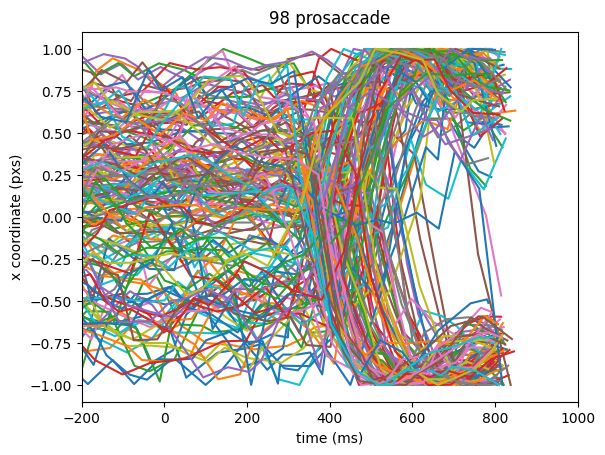

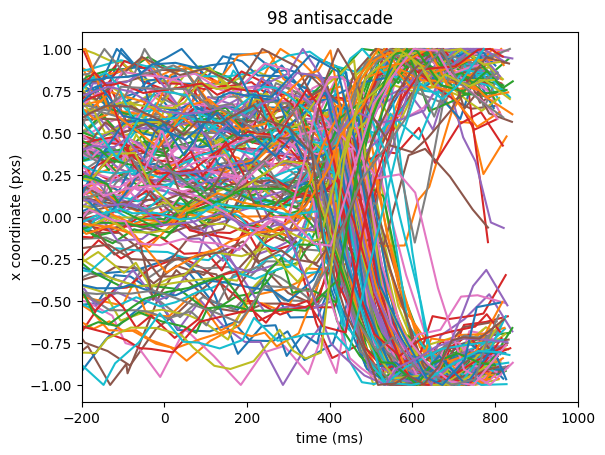

---
91


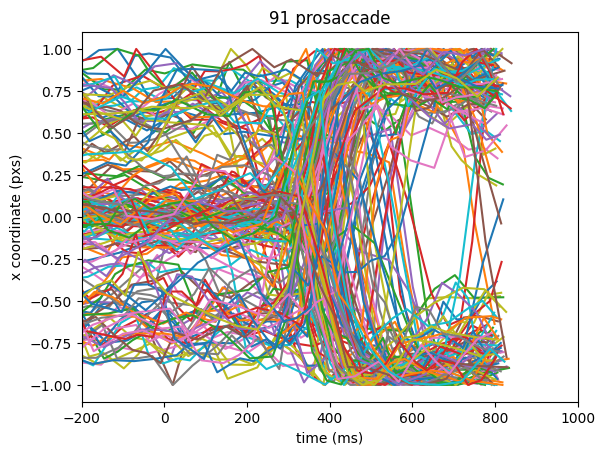

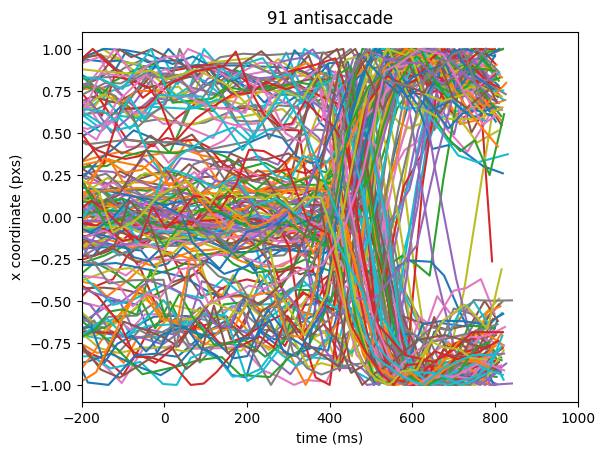

---
102


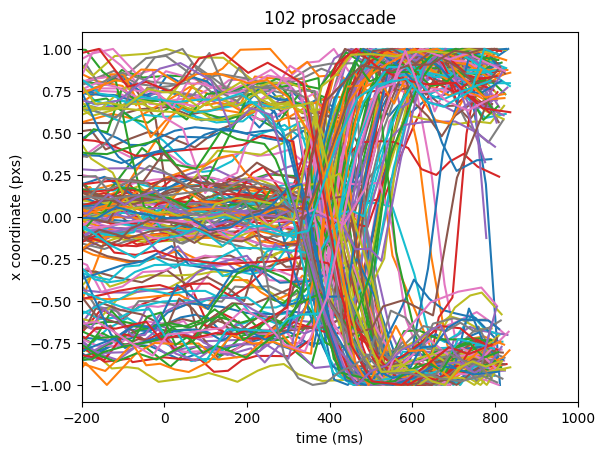

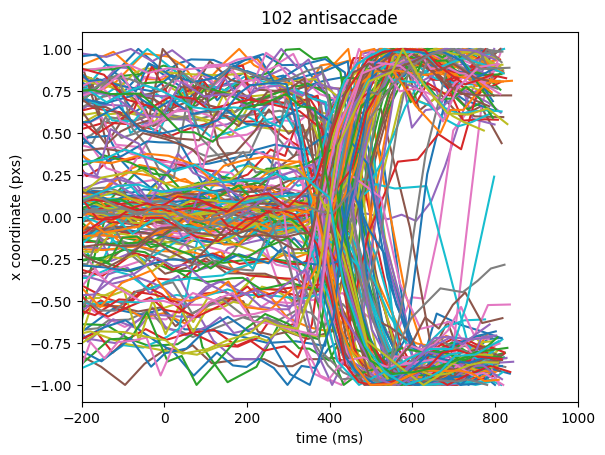

---
92


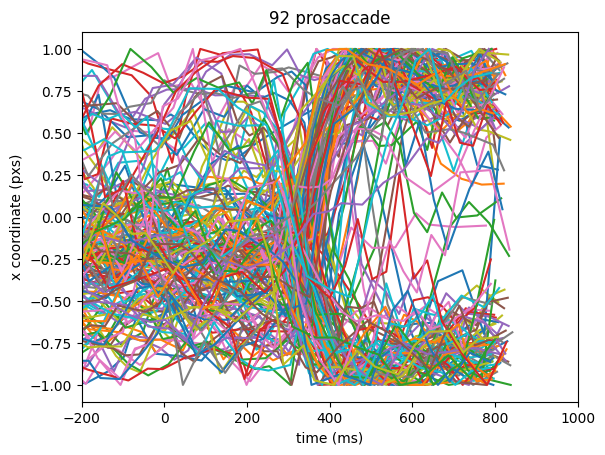

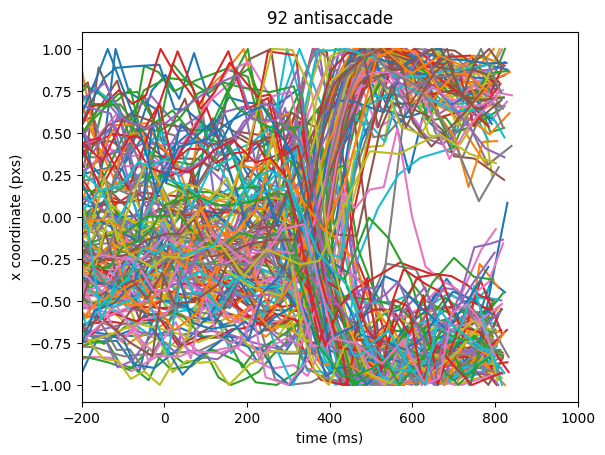

---
99


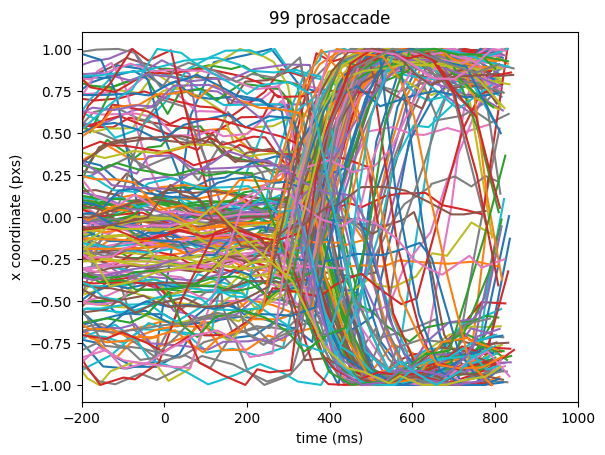

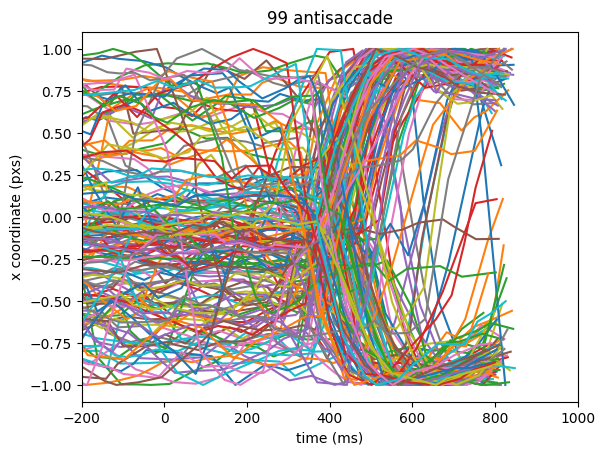

---
101


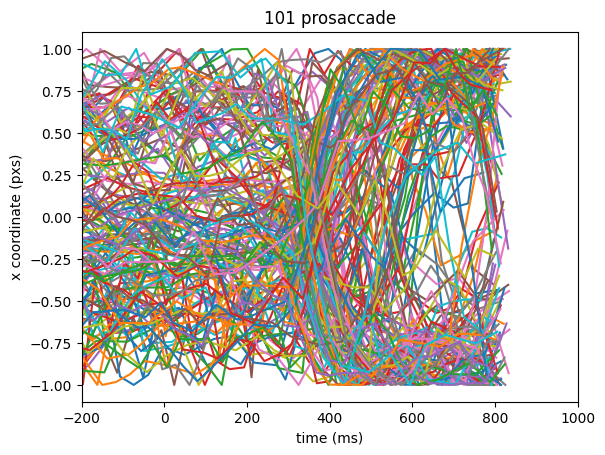

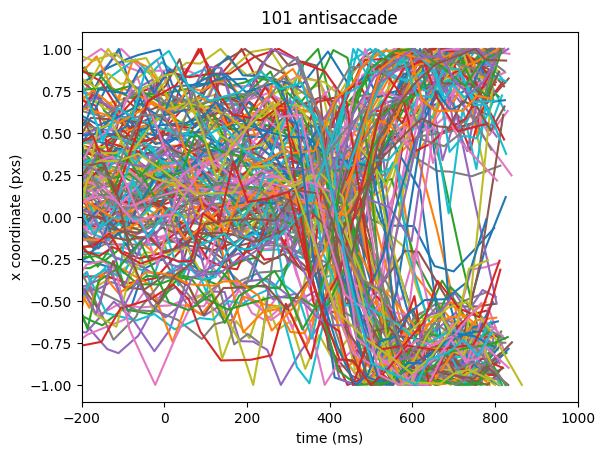

---
100


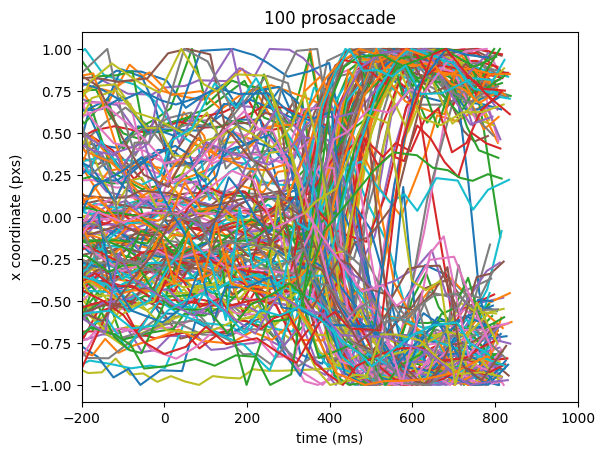

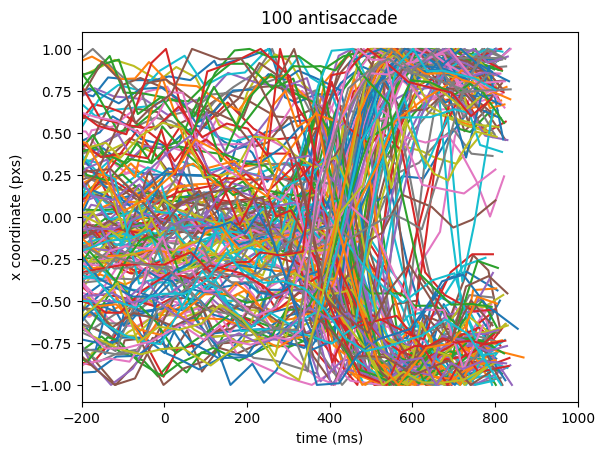

In [153]:
# Plot all subjects
for i in enumerate(ALL_FILES_RAW):
    print("---")
    suj = str(i).split('/')[-1].split('.')[0].split('_')[-1]
    print(suj)
    one_subject(df_processed_signal, suj, 'prosaccade')
    one_subject(df_processed_signal, suj, 'antisaccade')

In [129]:
df.head()

rt                                           stimulus  \
0    3567.0  \n    <div style="left: calc(50% - 400px); wid...   
1   33081.0                                                NaN   
2   36956.0  \n    <div style="left: calc(50% - 400px); wid...   
3  140386.0                                                NaN   
4    3116.0  \n    <div style="left: calc(50% - 400px); wid...   

                                            response            trial_type  \
0                                                  0  html-button-response   
1  {"anteojos":"si","age":"33","hand":"derecha","...      survey-html-form   
2                                                  0  html-button-response   
3                                                NaN      virtual-chinrest   
4                                                  0  html-button-response   

   trial_index  time_elapsed internal_node_id  run_id  condition  \
0            0          3570          0.0-0.0     100          1   
1            1         36657          0.0-1.0     100          1   
2            2         73615          0.0-2.0     100          1   
3            3        214005          0.0-3.0     100          1   
4            4        217124          0.0-4.0     100          1   

           recorded_at               source_code_version  ip  \
0  2023-02-09 17:02:17  50d9939bf46dc3af64623b0b529c64ea NaN   
1  2023-02-09 17:02:17  50d9939bf46dc3af64623b0b529c64ea NaN   
2  2023-02-09 17:02:17  50d9939bf46dc3af64623b0b529c64ea NaN   
3  2023-02-09 17:02:17  50d9939bf46dc3af64623b0b529c64ea NaN   
4  2023-02-09 17:02:17  50d9939bf46dc3af64623b0b529c64ea NaN   

                                          user_agent  device browser  \
0  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...  WebKit  Chrome   
1  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...  WebKit  Chrome   
2  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...  WebKit  Chrome   
3  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...  WebKit  Chrome   
4  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...  WebKit  Chrome   

  browser_version platform  platform_version  item_width_mm  item_height_mm  \
0       107.0.0.0    Linux               NaN            NaN             NaN   
1       107.0.0.0    Linux               NaN            NaN             NaN   
2       107.0.0.0    Linux               NaN            NaN             NaN   
3       107.0.0.0    Linux               NaN           85.6           53.98   
4       107.0.0.0    Linux               NaN            NaN             NaN   

   item_width_px  px2mm  view_dist_mm  item_width_deg     px2deg  \
0            NaN    NaN           NaN             NaN        NaN   
1            NaN    NaN           NaN             NaN        NaN   
2            NaN    NaN           NaN             NaN        NaN   
3          309.0   3.61        489.77        9.988548  30.935429   
4            NaN    NaN           NaN             NaN        NaN   

   win_width_deg  win_height_deg success timeout failed_images failed_audio  \
0            NaN             NaN     NaN     NaN           NaN          NaN   
1            NaN             NaN     NaN     NaN           NaN          NaN   
2            NaN             NaN     NaN     NaN           NaN          NaN   
3      54.306666       27.864492     NaN     NaN           NaN          NaN   
4            NaN             NaN     NaN     NaN           NaN          NaN   

  failed_video jspsych_start_time  load_time response_type key_press  \
0          NaN                NaN        NaN           NaN       NaN   
1          NaN                NaN        NaN           NaN       NaN   
2          NaN                NaN        NaN           NaN       NaN   
3          NaN                NaN        NaN           NaN       NaN   
4          NaN                NaN        NaN           NaN       NaN   

   avg_frame_time  center_x  center_y rastoc-type stimulus-coordinate  \
0             NaN       NaN       NaN         NaN  

In [157]:
# pre processing

# Siguiendo la tesis de Fran:

# 1. 
# El primer punto que se atacó fue la variabilidad de la frecuencia de muestreo. Para esto
# se realizó un remuestreo de las estimaciones de todo ensayo a 30 Hz. Esto se hizo utilizando
# interpolación lineal 

# 2.
#  Las estimaciones fueron luego normalizadas tal que el valor 0 se correspondiera con
# la posición de fijación. Para la primera ronda se calculó para cada sujeto el promedio de
# la coordenada “x” estimada durante la fase de fijación de cada ensayo. A las estimaciones
# de los ensayos de cada sujeto se sustrajo luego tal valor con el fin de centrarlos alrededor
# del 0. Cada ensayo fue luego llevado al rango [−1, 1] tal que aproximadamente −1 se
# correspondiera al valor mínimo del ensayo y 1 al valor máximo



def interpolate_between(x, xa, ya, xb, yb):
    """FUncion hecha por fran para interpolar
    """
    # Here x and y are not used as the screen coordinates but as the
    # classic horizontal vs vertical axis.
    # Check https://en.wikipedia.org/wiki/Interpolation#Linear_interpolation
    if not xa <= x <= xb:
        raise Exception('can not interpolate outside of input points')
    return ya + (yb - ya) * (x - xa) / (xb - xa)

def interpolate(t, axis):
    if t >= tn + TARGET_SAMPLING_PERIOD_IN_MS:
        raise Exception('input time is too big to interpolate')
    if t >= tn:
        return trial['estimations'][-1][axis]

    # find first bucket in which `t` is contained
    for i in range(1, len(trial['estimations'])):
        if trial['estimations'][i]['t'] > t:
            # this is the bucket since estimations are sorted by time
            past_estimation = trial['estimations'][i - 1]
            future_estimation = trial['estimations'][i]
            return interpolate_between(
                t,
                past_estimation['t'], past_estimation[axis],
                future_estimation['t'], future_estimation[axis],
            )
    raise Exception('you should not be here')

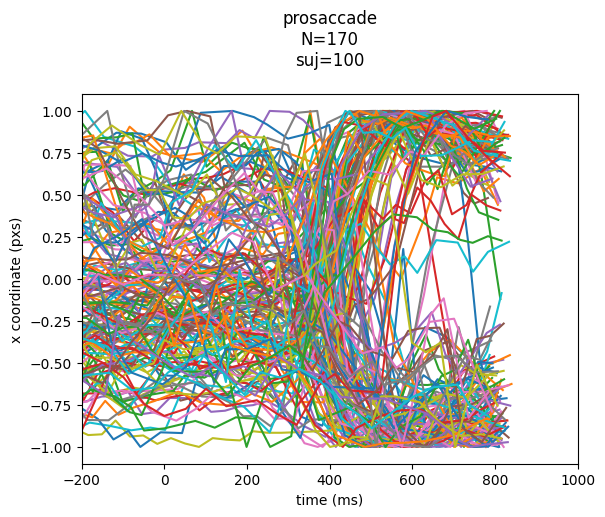

In [156]:
type_of_saccade = 'prosaccade'
df_saccade = df.query("not webgazer_data.isnull() and typeOfSaccade == @type_of_saccade")
webgazer_data = df_saccade['webgazer_data'].map(eval)
ts_xs = []

for trial in range(len(webgazer_data)):
    t0 = df_saccade['intraEnd'].iloc[trial]
    tf =  df_saccade['fixEnd'].iloc[trial] # Deberia ser t0 - 200
    xs = np.array([i['x'] for i in webgazer_data.iloc[trial]])
    ys = np.array([i['y'] for i in webgazer_data.iloc[trial]])
    ts = np.array([i['t'] - t0 for i in webgazer_data.iloc[trial]])
    xbase = np.mean(xs[(ts>-200.0) & (ts<0.0)]) 
    # 1. Substract baseline (mean of 200 ms)
    xs = xs - xbase 
    # 2. Normalize in range [-1, 1]
    xs_normalized = normalize_in_range(xs, -1, 1)
    ts_xs.append((ts, xs_normalized))
    
    plt.plot(ts, xs_normalized)

plt.title(f'{type_of_saccade}\nN={len(webgazer_data)}\nsuj={suj}\n')
plt.ylabel('x coordinate (pxs)')
plt.xlabel('time (ms)')
plt.xlim(-200, 1000)
plt.show()

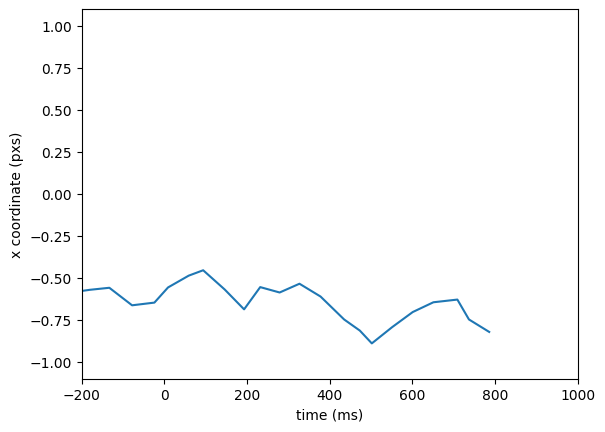

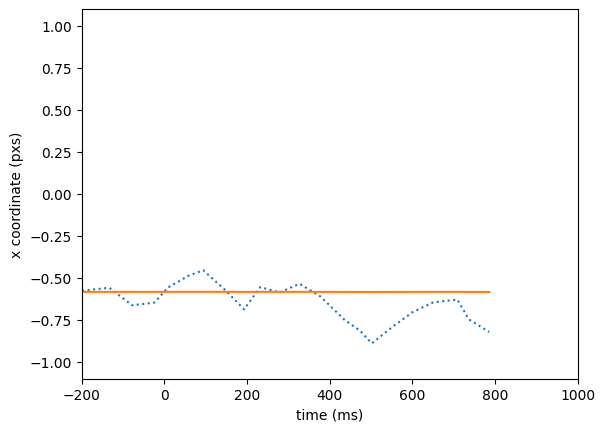

In [176]:
from scipy.interpolate import interp1d
 
f1 = interp1d(ts,xs_normalized, kind='linear') 

plt.plot(ts, xs_normalized, ':', ts, f1(xs_normalized), '-')
plt.ylabel('x coordinate (pxs)')
plt.xlabel('time (ms)')
plt.xlim(-200, 1000)
plt.show()

(array([ 2.,  0.,  1., 10., 33., 19.,  4.,  0.,  0.,  2.]),
 array([-0.64794383, -0.51273821, -0.3775326 , -0.24232698, -0.10712136,
         0.02808425,  0.16328987,  0.29849549,  0.4337011 ,  0.56890672,
         0.70411234]),
 <BarContainer object of 10 artists>)

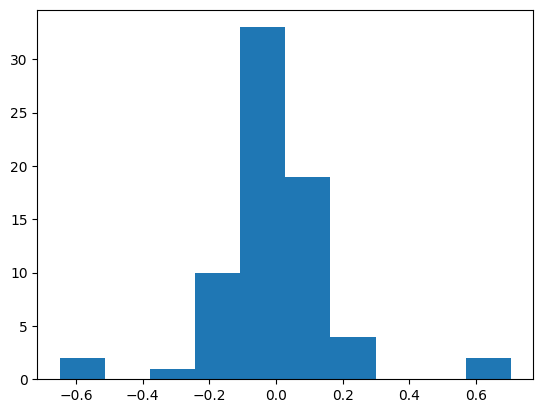

In [178]:
plt.hist( np.diff(xs_normalized))

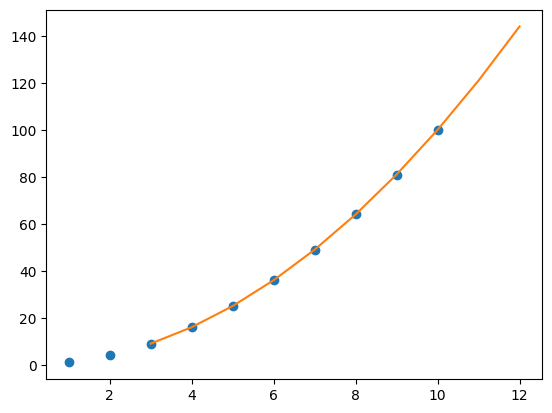

In [179]:
x = (list(range(1,11)))
y = [i**2 for i in x]
xnew = [i+2 for i in range(1,11)]
ynew = [i**2 for i in xnew]

plt.plot(x, y, 'o', xnew, ynew, '-')
